In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("student-por.csv", sep=';')
print("Jumlah baris dan kolom:", df.shape)
df.head()

Jumlah baris dan kolom: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Pada bagian ini dilakukan pemeriksaan terhadap nilai yang hilang (missing values) menggunakan isnull().sum(). Jika ditemukan nilai yang hilang pada kolom numerik, maka nilainya diisi menggunakan median, karena median lebih tahan terhadap pengaruh outlier dibandingkan rata-rata. Sedangkan untuk kolom bertipe kategorikal, nilai yang hilang diisi dengan modus, yaitu nilai yang paling sering muncul. Pengisian ini dilakukan agar tidak ada data kosong yang dapat mengganggu analisis atau menyebabkan error saat membangun model. Secara umum, langkah ini menjaga integritas data tanpa harus menghapus terlalu banyak baris.

In [3]:
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

Tahapan ini bertujuan untuk menghapus data yang memiliki nilai ganda (duplikat). Data duplikat dapat menimbulkan bias karena informasi yang sama dihitung lebih dari sekali. Fungsi df.duplicated() digunakan untuk mendeteksi duplikat, dan drop_duplicates(inplace=True) digunakan untuk menghapusnya secara permanen dari dataset. Setelah dihapus, jumlah duplikat dicek kembali untuk memastikan bahwa data sudah bersih dari pengulangan. Dengan begitu, dataset menjadi lebih konsisten dan representatif terhadap populasi sebenarnya.

In [4]:
duplicates = df.duplicated().sum()
print("Jumlah data duplikat:", duplicates)
df.drop_duplicates(inplace=True)
print("Jumlah data setelah dihapus:", df.duplicated().sum())

Jumlah data duplikat: 0
Jumlah data setelah dihapus: 0


Pada tahap ini dilakukan deteksi dan penanganan outlier, yaitu nilai ekstrem yang berbeda jauh dari data lainnya. Kolom yang dipilih untuk contoh adalah absences (jumlah ketidakhadiran siswa). Visualisasi awal menggunakan boxplot memperlihatkan keberadaan outlier. Metode Interquartile Range (IQR) digunakan untuk menentukan batas bawah dan atas data yang wajar. Nilai di luar rentang tersebut dianggap outlier dan dihapus. Setelah itu, boxplot kedua dibuat untuk memverifikasi bahwa nilai ekstrem telah dihilangkan. Penghapusan ini dilakukan agar data lebih seimbang dan tidak mempengaruhi hasil analisis secara berlebihan.

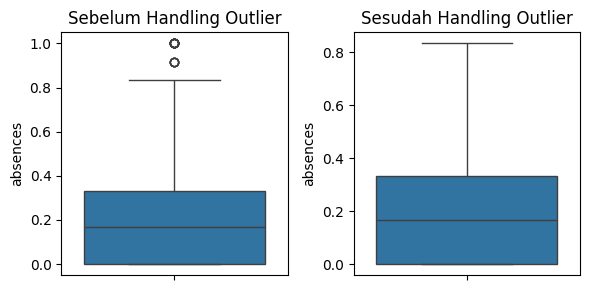

In [13]:
# Sebelum handling outlier
fig, axes = plt.subplots(1,2, figsize=(6,3))
sns.boxplot(df['absences'], orient='v', ax=axes[0])
axes[0].title.set_text("Sebelum Handling Outlier")

# Menggunakan metode IQR
Q1 = df['absences'].quantile(0.25)
Q3 = df['absences'].quantile(0.75)
IQR = Q3 - Q1
df['absences'] = df['absences'][~((df['absences'] < (Q1 - 1.5 * IQR)) | (df['absences'] > (Q3 + 1.5 * IQR)))]

# Setelah handling outlier
sns.boxplot(df['absences'], orient='v', ax=axes[1])
axes[1].title.set_text("Sesudah Handling Outlier")
plt.tight_layout()
plt.show()

Proses normalisasi dilakukan pada semua kolom numerik menggunakan metode Min-Max Scaling yang mengubah skala nilai menjadi antara 0 dan 1. Hal ini bertujuan agar setiap fitur memiliki rentang nilai yang sama dan tidak ada kolom yang mendominasi perhitungan hanya karena memiliki skala besar. Normalisasi juga membantu mempercepat proses pelatihan model dan meningkatkan performa algoritma yang sensitif terhadap skala data, seperti KNN dan neural network. Setelah normalisasi, data menjadi lebih seragam dan siap untuk tahap berikutnya.

In [8]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df[num_cols].head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0.428571,1.00,1.00,0.333333,0.333333,0.0,0.75,0.50,0.75,0.00,0.00,0.5,0.333333,0.000000,0.578947,0.578947
1,0.285714,0.25,0.25,0.000000,0.333333,0.0,1.00,0.50,0.50,0.00,0.00,0.5,0.166667,0.473684,0.578947,0.578947
2,0.000000,0.25,0.25,0.000000,0.333333,0.0,0.75,0.50,0.25,0.25,0.50,0.5,0.500000,0.631579,0.684211,0.631579
3,0.000000,1.00,0.50,0.000000,0.666667,0.0,0.50,0.25,0.25,0.00,0.00,1.0,0.000000,0.736842,0.736842,0.736842
4,0.142857,0.75,0.75,0.000000,0.333333,0.0,0.75,0.50,0.25,0.00,0.25,1.0,0.000000,0.578947,0.684211,0.684211


Encoding digunakan untuk mengubah data kategorikal (berbentuk teks) menjadi data numerik agar dapat diproses oleh algoritma machine learning. Dalam tahap ini digunakan metode One-Hot Encoding dengan fungsi pd.get_dummies(). Setiap kategori unik dalam kolom akan diubah menjadi kolom baru dengan nilai biner (0 atau 1). Parameter drop_first=True digunakan untuk menghindari multicollinearity atau dummy variable trap dengan cara menghapus satu kolom dari setiap kategori. Dengan langkah ini, seluruh variabel kategorikal dapat digunakan dalam analisis atau model tanpa menyebabkan kesalahan interpretasi.

In [15]:
cat_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,average_grade
0,0.428571,1.00,1.00,0.333333,0.333333,0.0,0.75,0.50,0.75,0.00,...,False,True,False,False,False,True,True,False,False,0.385965
1,0.285714,0.25,0.25,0.000000,0.333333,0.0,1.00,0.50,0.50,0.00,...,False,False,True,False,False,False,True,True,False,0.543860
2,0.000000,0.25,0.25,0.000000,0.333333,0.0,0.75,0.50,0.25,0.25,...,False,True,False,False,False,True,True,True,False,0.649123
3,0.000000,1.00,0.50,0.000000,0.666667,0.0,0.50,0.25,0.25,0.00,...,False,False,True,False,True,True,True,True,True,0.736842
4,0.142857,0.75,0.75,0.000000,0.333333,0.0,0.75,0.50,0.25,0.00,...,False,False,True,False,False,True,True,False,False,0.649123


Feature engineering adalah proses menciptakan fitur baru yang lebih informatif berdasarkan data yang sudah ada. Di sini dibuat kolom baru bernama average_grade yang merupakan rata-rata dari tiga nilai ujian siswa, yaitu G1, G2, dan G3. Fitur ini membantu memberikan gambaran umum mengenai performa akademik siswa secara keseluruhan, bukan hanya berdasarkan satu ujian. Dengan adanya fitur baru ini, analisis menjadi lebih bermakna karena memperhitungkan tren performa siswa dari waktu ke wak

In [16]:
# Membuat kategori berdasarkan rata-rata nilai siswa
bins = [0, 5, 10, 15, 20]
labels = ['Low', 'Medium', 'Good', 'Excellent']
df['grade_category'] = pd.cut(df['G3'], bins=bins, labels=labels)
df[['G3', 'grade_category']].head()


,G3,grade_category
0,0.578947,Low
1,0.578947,Low
2,0.631579,Low
3,0.736842,Low
4,0.684211,Low


Langkah terakhir adalah membagi dataset menjadi dua bagian: training set dan testing set. Proses ini menggunakan fungsi train_test_split dengan pembagian 80% data untuk pelatihan model dan 20% untuk pengujian. Variabel X berisi semua fitur kecuali kolom target G3, sedangkan y berisi nilai G3 yang akan diprediksi. Parameter random_state=42 digunakan agar hasil pembagian tetap konsisten setiap kali dijalankan. Dengan pemisahan ini, kita dapat melatih model pada data training dan mengevaluasi performanya secara objektif pada data testing.

In [17]:
# Subset feature dan target
X = df.drop(columns=['G3'])
y = df['G3']

# Splitting data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Melihat dimensi data
print('Dimensi X_train:', X_train.shape)
print('Dimensi X_test:', X_test.shape)
print('Dimensi y_train:', y_train.shape)
print('Dimensi y_test:', y_test.shape)


Dimensi X_train: (493, 43)
Dimensi X_test: (124, 43)
Dimensi y_train: (493,)
Dimensi y_test: (124,)
